In [43]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import re
import pandas as pd
import numpy as np
import os
from random import shuffle
import time 
import random

import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.plots import plot_objective
from skopt.utils import use_named_args

<div class="alert alert-block alert-info">
<b>Loading data for creating the model:</b> We will load the dataset containing question and answer pairs for creating the model.
</div>

In [2]:
df_professional = pd.read_csv('qna_chitchat_caring.tsv',sep='\t')

<div class="alert alert-block alert-info">
<b>Data Preprocessing:</b> The preprocessing step involves picking up the columnsrelated to questions and answers only, splitting the texts to remove punctuations and numbers and finally adding 'start of sentence' and 'end of sentence' token that will help the model in knowing where a word is starting and where it is ending. The process will be followed both for questions and answers data separately 
</div>

In [3]:
clean_text                  = []
for i in range(len(df_professional)):
    ques_text               = df_professional.loc[i]['Question']
    ans_text                = df_professional.loc[i]['Answer']
    
    ques_text_split         = ques_text.split()
    ans_text_split          = ans_text.split()
    
    ques_text__punc_removed = ' '.join([re.sub('[^A-Za-z]+', '', ques_text_split[i]) for i in range(len(ques_text_split))])
    ans_text_punc_removed   = ' '.join([re.sub('[^A-Za-z]+', '', ans_text_split[i]) for i in range(len(ans_text_split))])
    
    
    ques_text_nums_removed  = ' '.join([word.lower() for word in ques_text__punc_removed.split() if word.isalpha()])
    ans_text_nums_removed   = ' '.join([word.lower() for word in ans_text_punc_removed.split() if word.isalpha()])
    
    ques_text_final         = '<start> '+ques_text_nums_removed + ' <end>'
    ans_text_final          = '<start> '+ans_text_nums_removed + ' <end>'
    clean_text.append([ques_text_final,ans_text_final])
clean_text                  = np.array(clean_text)
print('Punctuations removed and all the sentences converted to smaller case.')
print('Example of preprocessed Question Sentence is :- ',clean_text[1200][0])
print('Example of preprocessed Answer Sentence is :- ',clean_text[1200][1])

Punctuations removed and all the sentences converted to smaller case.
Example of preprocessed Question Sentence is :-  <start> youre in a good mood today <end>
Example of preprocessed Answer Sentence is :-  <start> im quite content <end>


<div class="alert alert-block alert-info">
<b>Tokenizing:</b> Both Questions and Answers data will be tokenized to get the distinct words and maximum length of a sentence in a Question set as well as in an answer set (Tx and Ty). We will use the tokenizers later in the training process. 
</div>

In [4]:
ques_tokenizer       = tf.keras.preprocessing.text.Tokenizer(filters='')
ques_tokenizer.fit_on_texts(clean_text[:,0])
question_vocab       = len(ques_tokenizer.word_index) + 1
question_length      = max([len(clean_text[:,0][i].split()) for i in range(len(clean_text[:,0]))])
print('The number of distinct words in the Questions is ',question_vocab)
print('The maximum length of sentence in Question is    ',question_length)
ques_tensor_tokenized= ques_tokenizer.texts_to_sequences(clean_text[:,0])
tensor_question      = tf.keras.preprocessing.sequence.pad_sequences(ques_tensor_tokenized,padding='post')

The number of distinct words in the Questions is  2030
The maximum length of sentence in Question is     17


In [5]:
ans_tokenizer        = tf.keras.preprocessing.text.Tokenizer(filters='')
ans_tokenizer.fit_on_texts(clean_text[:,1])
ans_vocab            = len(ans_tokenizer.word_index) + 1
ans_length           = max([len(clean_text[:,1][i].split()) for i in range(len(clean_text[:,1]))])
print('The number of distinct words in the Answers is ',ans_vocab)
print('The maximum length of sentence in Answers is   ',ans_length)
ans_tensor_tokenized = ans_tokenizer.texts_to_sequences(clean_text[:,1])
tensor_answer        = tf.keras.preprocessing.sequence.pad_sequences(ans_tensor_tokenized,padding='post')

The number of distinct words in the Answers is  237
The maximum length of sentence in Answers is    21


<div class="alert alert-block alert-info">
<b>Train Test Split :</b> The data will be divided to train and test split.
</div>

In [6]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(tensor_question, tensor_answer, test_size=0.2)
max_length_targ = input_tensor_val.shape[1]
max_length_inp  = input_tensor_train.shape[1]

<div class="alert alert-block alert-info">
<b>Encoder class:</b> The encoder class takes the questions and input and outputs a thought vector in form of the hidden state of a GRU. We also initialize the hidden state to zeros to ease the training process (we could have initialized it randomly as well)
</div>

In [7]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

<div class="alert alert-block alert-info">
<b>Attention Layer:</b> Since we have obtained the thoughtvector from the Encoder layer, we will use attention weights to transform the thought vector to a context vector where the weights corresponding to respective input places (from 1 to Tx) is applied to the thought vector in form of a function. The context vector will be the input to the Decoder layer
</div>

In [8]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        hidden_with_time_axis = tf.expand_dims(query, 1)
        score                 = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))
        attention_weights     = tf.nn.softmax(score, axis=1)
        context_vector        = attention_weights * values
        context_vector        = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights


<div class="alert alert-block alert-info">
<b>Decoder Layer:</b> This module will take the encoder hidden state and then convert it to context vector which will be used as an input to the GRU state. The output will be a vector of size (less than) or equal to Ty. That output hidden layer will be preprocessed to get the anwer to the question that was input in the Encoder layer.
</div>

In [9]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz  = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru       = tf.keras.layers.GRU(self.dec_units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.fc        = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)
        x                                 = self.embedding(x)
        x                                 = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state                     = self.gru(x)
        output                            = tf.reshape(output, (-1, output.shape[2]))
        x                                 = self.fc(output)
        return x, state, attention_weights


<div class="alert alert-block alert-info">
<b>Parameters to the model:</b> Some parameters are set for the model. However we will use the parameter tuning for embedding dimensions, units(hiddden units for Attention layer)
</div>

In [10]:
BUFFER_SIZE     = len(input_tensor_train)
BATCH_SIZE      = 32
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim   = 256
units           = 1048
vocab_inp_size  = len(ques_tokenizer.word_index)+1
vocab_tar_size  = len(ans_tokenizer.word_index)+1
dataset         = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset         = dataset.batch(BATCH_SIZE, drop_remainder=True)

<div class="alert alert-block alert-info">
<b>Loss function :</b> Loss function will be created to be used to measure losses at teacher forcing step
</div>

In [11]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
    mask   = tf.math.logical_not(tf.math.equal(real, 0))
    loss_  = loss_object(real, pred)
    mask   = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

<div class="alert alert-block alert-info">
<b>Training step :</b> Here we are going to train the model and enforce teacher forcing steps.
</div>

In [12]:
#@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    
    with tf.GradientTape() as tape:
    
        enc_output, enc_hidden     = encoder(inp, enc_hidden)
    
        dec_hidden                 = enc_hidden
        dec_input                  = tf.expand_dims([ans_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)
        for t in range(1, targ.shape[1]):
    
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
    
            loss += loss_function(targ[:, t], predictions)
            dec_input                  = tf.expand_dims(targ[:, t], 1)

    batch_loss                     = (loss / int(targ.shape[1]))
    variables                      = encoder.trainable_variables + decoder.trainable_variables
    
    gradients                      = tape.gradient(loss, variables)
    
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

<div class="alert alert-block alert-info">
<b>Hyper parameter margin and initialization:</b> We set up initial values of the Hyper parameters to start with and also specify the range within which we want to find the values of the hyper parameters. The optimal weights corresponding to encoders and decoders will be stored for the least loss attained 
</div>

In [15]:
learning_rate      = Real(low=1e-6, high=1e-2, prior='log-uniform',name='learning_rate')
units              = Integer(low=600, high=1050, name='units')
embedding_dim      = Integer(low=10,high=300,name='embedding_dim')
#batch_size         = Integer(low=4,high=128,name='batch_size')
dimensions         = [learning_rate,units,embedding_dim]
default_parameters = [0.005, 650,256]
best_accuracy      = 0.0
path_best_model    = 'chatbot_best_model_attention.keras'
best_loss          = 1000
test_results       = []

In [18]:
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, units,embedding_dim):
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('Units :', units)
    print('Embedding size:', embedding_dim)
    EPOCHS      = 5
    global optimizer
    optimizer   = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    global encoder
    encoder     = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
    global decoder
    decoder     = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
    
    for epoch in range(EPOCHS):
        start = time.time()
        enc_hidden = encoder.initialize_hidden_state()
        total_loss = 0
        for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
            batch_loss = train_step(inp, targ, enc_hidden)
            total_loss += batch_loss
            if batch % 50 == 0:
                print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,batch,batch_loss.numpy()))
        
        print('Epoch {} Loss {:.4f}'.format(epoch + 1,total_loss / steps_per_epoch))
        print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    Loss = float(total_loss/ steps_per_epoch)
    print("Loss: ",Loss)
    
    global best_loss
    if Loss < best_loss:
        best_loss = Loss
        encoder_weights_path = 'D:\\training_checkpoints\\encoder_weights\\enc.h5'
        decoder_weights_path = 'D:\\training_checkpoints\\decoder_weights\\dec.h5'
        encoder.save_weights(encoder_weights_path)
        decoder.save_weights(decoder_weights_path)
        output_dict = {'encoder':encoder,'decoder':decoder,
                       'loss':Loss,'units':int(units),'embedding_size':int(embedding_dim)}
        test_results.append(output_dict)
    tf.keras.backend.clear_session()
    return Loss

In [19]:
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=15,
                            x0=default_parameters)

learning rate: 5.0e-03
Units : 650
Embedding size: 256
Epoch 1 Batch 0 Loss 1.9285
Epoch 1 Batch 50 Loss 0.4107
Epoch 1 Batch 100 Loss 0.3379
Epoch 1 Batch 150 Loss 0.2320
Epoch 1 Loss 0.5541
Time taken for 1 epoch 53.475921630859375 sec

Epoch 2 Batch 0 Loss 0.2458
Epoch 2 Batch 50 Loss 0.0814
Epoch 2 Batch 100 Loss 0.0833
Epoch 2 Batch 150 Loss 0.0491
Epoch 2 Loss 0.1132
Time taken for 1 epoch 53.13115859031677 sec

Epoch 3 Batch 0 Loss 0.0768
Epoch 3 Batch 50 Loss 0.0265
Epoch 3 Batch 100 Loss 0.0238
Epoch 3 Batch 150 Loss 0.0854
Epoch 3 Loss 0.0504
Time taken for 1 epoch 53.10770535469055 sec

Epoch 4 Batch 0 Loss 0.0124
Epoch 4 Batch 50 Loss 0.0225
Epoch 4 Batch 100 Loss 0.0220
Epoch 4 Batch 150 Loss 0.0263
Epoch 4 Loss 0.0232
Time taken for 1 epoch 53.08648204803467 sec

Epoch 5 Batch 0 Loss 0.0202
Epoch 5 Batch 50 Loss 0.0453
Epoch 5 Batch 100 Loss 0.0834
Epoch 5 Batch 150 Loss 0.0717
Epoch 5 Loss 0.0441
Time taken for 1 epoch 52.97817087173462 sec

Loss:  0.04405184090137482
le

Epoch 2 Batch 0 Loss 0.4611
Epoch 2 Batch 50 Loss 0.3484
Epoch 2 Batch 100 Loss 0.3527
Epoch 2 Batch 150 Loss 0.3108
Epoch 2 Loss 0.3873
Time taken for 1 epoch 53.71919560432434 sec

Epoch 3 Batch 0 Loss 0.2621
Epoch 3 Batch 50 Loss 0.2993
Epoch 3 Batch 100 Loss 0.2560
Epoch 3 Batch 150 Loss 0.1988
Epoch 3 Loss 0.2207
Time taken for 1 epoch 53.84934759140015 sec

Epoch 4 Batch 0 Loss 0.1871
Epoch 4 Batch 50 Loss 0.1707
Epoch 4 Batch 100 Loss 0.1572
Epoch 4 Batch 150 Loss 0.1082
Epoch 4 Loss 0.1328
Time taken for 1 epoch 54.034343957901 sec

Epoch 5 Batch 0 Loss 0.1076
Epoch 5 Batch 50 Loss 0.0893
Epoch 5 Batch 100 Loss 0.0667
Epoch 5 Batch 150 Loss 0.0841
Epoch 5 Loss 0.0810
Time taken for 1 epoch 53.58395004272461 sec

Loss:  0.08102484792470932
learning rate: 8.4e-05
Units : 863
Embedding size: 179
Epoch 1 Batch 0 Loss 1.9854
Epoch 1 Batch 50 Loss 1.4924
Epoch 1 Batch 100 Loss 1.5235
Epoch 1 Batch 150 Loss 1.7869
Epoch 1 Loss 1.6852
Time taken for 1 epoch 59.26762270927429 sec

Epoch

<div class="alert alert-block alert-info">
<b>Hyper parameter tuning resuts: </b> We can see that the tuning of the parameters gave us results and out minimum loss was attained at the 15th call to the training function by the minimizer. We could have got better results if we increased the number of calls to the training function
</div>

In [21]:
print('The Minimum Loss reached is :- ',search_result.fun)

The Minimum Loss reached is :-  0.018955636769533157


In [28]:
units         = search_result.x[1]
embedding_dim = search_result.x[2]

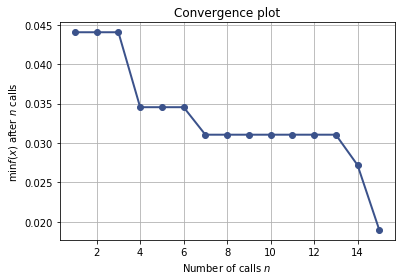

In [35]:
plot_convergence(search_result)

<div class="alert alert-block alert-info">
<b>Evaluate: </b> We will now create a function to apply the model prepared with the tuned parameters to any input question sentence to provide the desired output in form of an answer.
</div>

In [40]:
def evaluate(sentence):
    optimizer   = tf.keras.optimizers.Adam(learning_rate=search_result.x[0])
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    input_ques_split        = sentence.split()
    ques_text_punc_removed = ' '.join([re.sub('[^A-Za-z]+', '', input_ques_split[i]) for i in range(len(input_ques_split))])
    ques_text_nums_removed = ' '.join([word.lower() for word in ques_text_punc_removed.split() if word.isalpha()])
    sentence                  = '<start> '+ques_text_nums_removed + ' <end>'
    inputs = [ques_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                       maxlen=input_tensor_train.shape[1],
                                                       padding='post')
    inputs = tf.convert_to_tensor(inputs)
    result = ''

    hidden = [tf.zeros((1, units))]
    encoder.load_weights('D:\\training_checkpoints\\encoder_weights\\enc.h5')
    decoder.load_weights('D:\\training_checkpoints\\decoder_weights\\dec.h5')
    
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([ans_tokenizer.word_index['<start>']], 0)

    for t in range(input_tensor_val.shape[1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += ans_tokenizer.index_word[predicted_id] + ' '

        if ans_tokenizer.index_word[predicted_id] == '<end>':
            return result

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result

<div class="alert alert-block alert-info">
<b>Generate Conversations: </b> The following code will generate the conversations randomly. We will also check the answer given by out bot and what was actually expected from it
</div>

In [41]:
def generate_conversation_randomly():
    word_index_dictionary_inputs = ques_tokenizer.word_index
    question_index_word_dict     =  {v: k for k, v in word_index_dictionary_inputs.items()}

    ans_ques_index_dictionary_inputs = ans_tokenizer.word_index
    answer_index_word_dict           =  {v: k for k, v in ans_ques_index_dictionary_inputs.items()}

    j             = random.randint(0,1200)
    question_list = [question_index_word_dict[i] if i>0 else '' for i in input_tensor_val[j] ] 
    input_ques    = ' '.join(question_list)
    input_questn  = input_ques.replace('<end>','').replace('<start>','')


    ans_sentence_list = [answer_index_word_dict[i] if i>0 else '' for i in target_tensor_val[j]] 
    input_answer      = ' '.join(ans_sentence_list)
    input_answer_exp  = input_answer.replace('<end>','').replace('<start>','')
    print('Query           :-',input_questn.strip())
    print('Bat-Bot reply   :-',evaluate(input_questn.strip()).replace('<end>',""))
    print('Answer Expected :-',input_answer_exp)

In [42]:
for i in range(20):
    generate_conversation_randomly()
    print('\n')

Query           :- between you and me who is more cute
Bat-Bot reply   :- i truly have no way to tell  
Answer Expected :-  i truly have no way to tell             


Query           :- this again
Bat-Bot reply   :- good night  
Answer Expected :-  i do repeat myself sometimes its something im working on          


Query           :- dont worry bot ill be back
Bat-Bot reply   :- take your time ill be here  
Answer Expected :-  take your time ill be here              


Query           :- should i go to therapy
Bat-Bot reply   :- i trust your judgment  
Answer Expected :-  i trust your judgment                


Query           :- is anyone available to chat to me
Bat-Bot reply   :- sure ask me a question  
Answer Expected :-  sure ask me a question               


Query           :- should i go to therapy
Bat-Bot reply   :- i trust your judgment  
Answer Expected :-  i trust your judgment                


Query           :- im canadian
Bat-Bot reply   :- okay  
Answer Expected :-  o

<div class="alert alert-block alert-info">
<b>Conclusion: </b> The answers are better than Seq2Seq models and we are getting complete answers to the questions asked. However there are some answers that are not as expected. We can improve the efficiency of our bot by increasing the sample size or allowing more callbacks to the tuning function.
</div>